In [22]:
import numpy as np
import torch
from torch.autograd import Variable
import os
import sys
import matplotlib.pyplot as plt

In [23]:
path_to_pydeformetrica = '/Users/maxime.louis/Documents/pydeformetrica'
sys.path.append(os.path.join(path_to_pydeformetrica, '../'))
from pydeformetrica.src.in_out.xml_parameters import XmlParameters
from pydeformetrica.src.in_out.dataset_functions import create_template_metadata
from pydeformetrica.src.in_out.deformable_object_reader import DeformableObjectReader
from pydeformetrica.src.core.model_tools.attachments.multi_object_attachment import MultiObjectAttachment
from pydeformetrica.src.support.kernels.kernel_functions import create_kernel
from pydeformetrica.src.support.utilities.general_settings import Settings
from src.in_out.array_readers_and_writers import *

In [34]:
path_to_sample = '/Users/maxime.louis/Documents/metric_learning/sample_image/sample_1'
path_to_atlas = '/Users/maxime.louis/Documents/metric_learning/sample_image/'
path_to_output = os.path.join(path_to_atlas, 'output')

In [35]:
# Xml parameters. 
initialized_model_xml_path = os.path.join(path_to_atlas, 'model_after_initialization.xml')


dataset_xml_path = os.path.join(path_to_atlas, 'data_set__sample_1.xml')
optimization_parameters_xml_path = os.path.join(path_to_atlas, 'optimization_parameters_saem.xml')

xml_parameters = XmlParameters()
xml_parameters.read_all_xmls(initialized_model_xml_path, dataset_xml_path, optimization_parameters_xml_path)

>> No initial CP spacing given: using diffeo kernel width of 0
>> Warning: context has already been set [ in xml_parameters ]. Ignoring.
>> State will be saved in file output/pydef_state.p


In [77]:
estimated_trajectory_path = os.path.join(path_to_output, 'LongitudinalMetricModel__EstimatedParameters__Trajectory.npy')
trajectory_parameters = np.load(estimated_trajectory_path)[()]
for key, val in trajectory_parameters.items():
    print(key, val.shape)


p0 (301, 4)
reference_time (301, 1)
v0 (301, 4)
onset_age_variance (301, 1)
log_acceleration_variance (301, 1)
noise_variance (301, 1)
modulation_matrix (301, 12)
metric_parameters (301, 4892)


In [78]:
true_parameters_path = os.path.join(path_to_sample, 'SimulatedData_all_fixed_effects.npy')
true_parameters = np.load(true_parameters_path)[()]
for key, val in true_parameters.items():
    print(key, val.shape)

p0 (4,)
reference_time ()
v0 (4,)
onset_age_variance ()
log_acceleration_variance ()
noise_variance ()
modulation_matrix (4, 3)
metric_parameters (4892,)


#1 Parameters recovery



iteration 9
reference_time 0.5
Final relative error for reference_time : 0.00912482850389


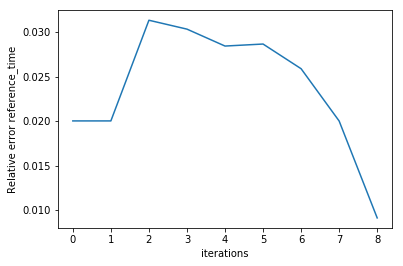

iteration 9
onset_age_variance 0.01
Final relative error for onset_age_variance : 4.50423963718


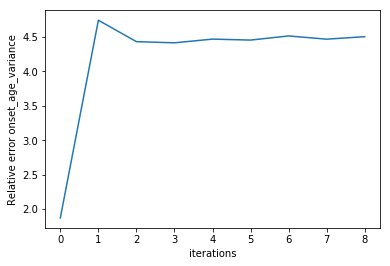

iteration 9
log_acceleration_variance 0.01
Final relative error for log_acceleration_variance : 12.4057122222


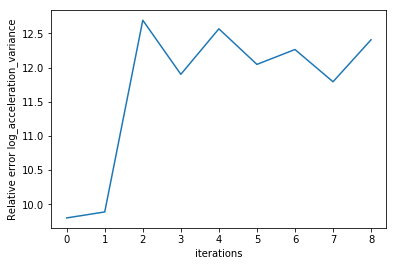

iteration 9
noise_variance 1e-06
Final relative error for noise_variance : 3665.31536398


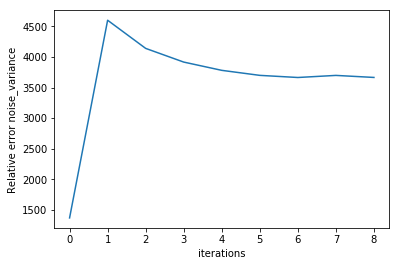

iteration 9
metric_parameters [-0.57201  -0.129036  0.079345 ...,  0.01672  -0.021325  0.071705]
Final relative error for metric_parameters : 1.02414649198


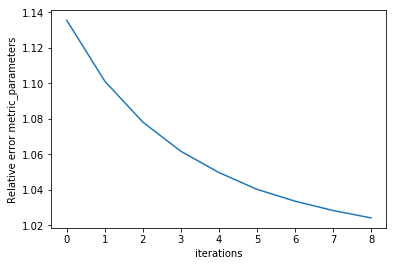

In [79]:
iteration_number = np.max(np.nonzero(trajectory_parameters['p0']))

for key in true_parameters.keys():
    if key not in ['p0', 'v0', 'modulation_matrix']:
        print("iteration", iteration_number)
        print(key, true_parameters[key])
        norm = np.linalg.norm(true_parameters[key])
        relative_error_traj = [np.linalg.norm(elt - true_parameters[key].flatten())/norm for elt in trajectory_parameters[key][:iteration_number]]
        print('Final relative error for', key, ':', relative_error_traj[-1])
        plt.plot(relative_error_traj)
        plt.xlabel('iterations')
        plt.ylabel('Relative error '+ key)
        plt.show()

# 2 Trajectory recovery

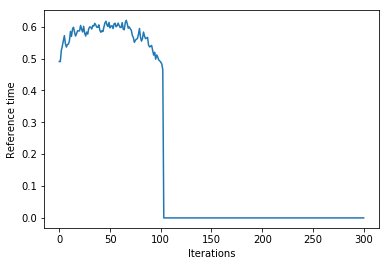

In [51]:
# reference_time.
reference_times = trajectory_all_parameters['reference_time']
plt.plot(reference_times)
plt.ylabel("Reference time")
plt.xlabel("Iterations")
plt.legend()
plt.show()

Number of nn parameters: 4892


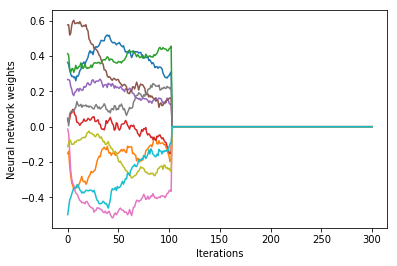

In [52]:
# neural network parameters
nn_parameters = trajectory_all_parameters['metric_parameters']
print('Number of nn parameters:', len(nn_parameters[0]))
for i in range(10):
    plt.plot(nn_parameters[:, i])
plt.ylabel("Neural network weights")
plt.xlabel("Iterations")
plt.show()
    

# 2. Individual random effects recovery


In [74]:
simulated_log_accelerations = np.loadtxt(os.path.join(path_to_sample, 'SimulatedData_log_accelerations.txt'))
estimated_log_accelerations = np.loadtxt(os.path.join(path_to_output, 'LongitudinalMetricModel_log_accelerations.txt'))
relative_error = 0
for i in range(len(simulated_log_accelerations)):
    relative_error += abs(estimated_log_accelerations[i] - simulated_log_accelerations[i])/abs(simulated_log_accelerations[i])
relative_error /= len(simulated_log_accelerations)
print(relative_error)

9.39628315904


In [75]:
simulated_onset_ages = np.loadtxt(os.path.join(path_to_sample, 'SimulatedData_onset_ages.txt'))
estimated_onset_ages = np.loadtxt(os.path.join(path_to_output, 'LongitudinalMetricModel_onset_ages.txt'))
relative_error = 0
for i in range(len(simulated_onset_ages)):
    relative_error += abs(estimated_onset_ages[i] - simulated_onset_ages[i])/abs(simulated_onset_ages[i])
relative_error /= len(simulated_onset_ages)
print(relative_error)

0.164902447583


In [76]:
simulated_sources = np.loadtxt(os.path.join(path_to_sample, 'SimulatedData_sources.txt'))
estimated_sources = np.loadtxt(os.path.join(path_to_output, 'LongitudinalMetricModel_sources.txt'))
relative_error = 0
for i in range(len(simulated_sources)):
    relative_error += np.linalg.norm(estimated_sources[i] - simulated_sources[i])/np.linalg.norm(simulated_sources[i])
relative_error /= len(simulated_sources)
print(relative_error)

0.935192246787


# 3 Absolute times

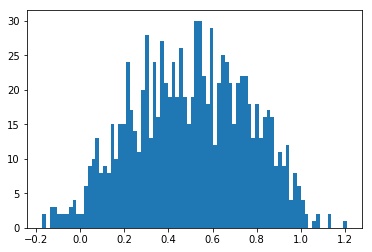

In [30]:
# Absolute times Plotting the histogram for the last observation
abs_times = np.loadtxt(os.path.join(path_to_output, "LongitudinalMetricModel_absolute_times.txt"))
plt.hist(abs_times, bins=80)
plt.show()

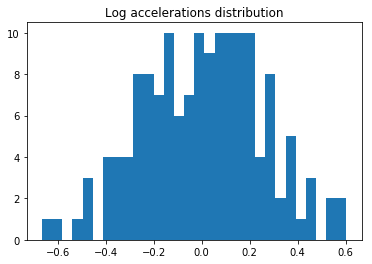

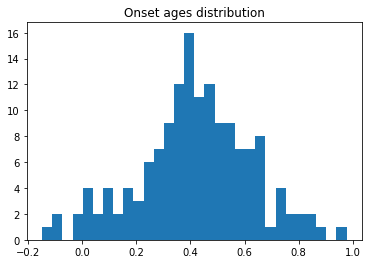

In [31]:
# Last realisations for the alphas and onset ages
log_accelerations = np.loadtxt(os.path.join(path_to_output, "LongitudinalMetricModel_log_accelerations.txt"))
onset_ages = np.loadtxt(os.path.join(path_to_output, "LongitudinalMetricModel_onset_ages.txt"))
plt.hist(log_accelerations, bins=30)
plt.title("Log accelerations distribution")
plt.show()
plt.hist(onset_ages, bins=30)
plt.title("Onset ages distribution")
plt.show()

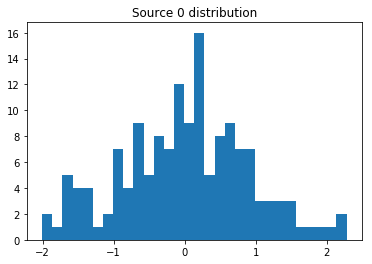

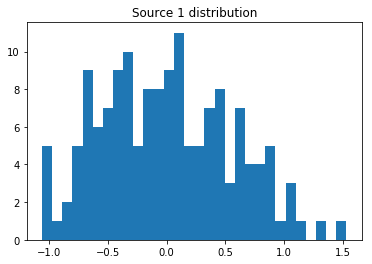

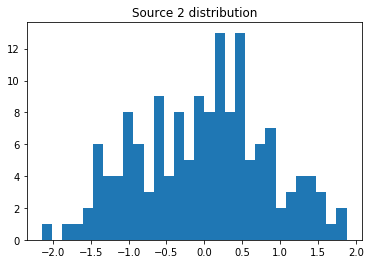

In [32]:
sources = np.loadtxt(os.path.join(path_to_output, "LongitudinalMetricModel_sources.txt"))
if len(sources.shape) == 1:
    sources = sources.reshape(len(sources), 1)
number_of_sources = len(sources[0])
for i in range(len(sources[0])):
    plt.hist(sources[:, i], bins=30)
    plt.title("Source "+str(i)+" distribution")
    plt.show()

# 3 Plotting some images


In [33]:
from PIL import Image
def load_image_trajectory(folder):
    image_paths = [elt for elt in os.listdir(folder) if elt.find('.png') >= 0]
    image_paths = sorted(image_paths, key=(lambda x: int(x[x.find('_t__')+4 : x.find('.png')])))
    to_keep = 5
    image_paths_aux = []
    if len(image_paths) > to_keep:
        stride = int(len(image_paths)/to_keep)
        for i in range(to_keep):
            image_paths_aux.append(image_paths[i*stride])
        image_paths = image_paths_aux
    return [np.array(Image.open(os.path.join(folder, elt)))/255 for elt in image_paths]
    
def plot_images(images):   
    plt.clf()
    f, axes = plt.subplots(1, len(images), figsize=(20, 10))
    max_intensity = np.max(np.array(images))
    min_intensity = np.min(np.array(images))
    for i,ax in enumerate(axes):
        im = ax.imshow(images[i], cmap='inferno', vmin=min_intensity, vmax=max_intensity)    
    f.subplots_adjust(right=0.8)
    cbar_ax = f.add_axes([0.85, 0.4, 0.01, 0.2])
    f.colorbar(im, cax=cbar_ax)
    plt.show()
        


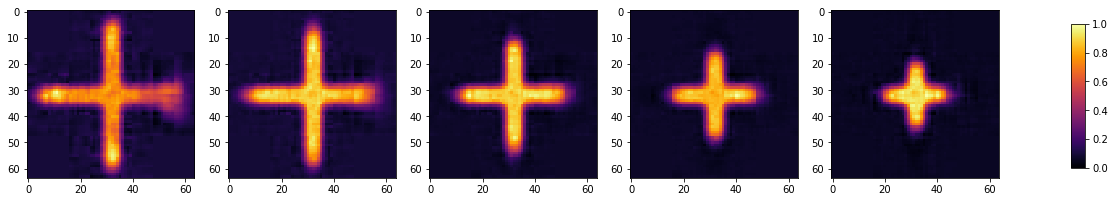

In [34]:
# Geodesic trajectory
geodesic_folder = os.path.join(path_to_output, 'geodesic_trajectory')
geodesic_images = load_image_trajectory(geodesic_folder)
plot_images(geodesic_images)

In [35]:
# First source
sources_traj = []
for i in range(number_of_sources):
    source_folder = os.path.join(path_to_output, 'parallel_curve_neg_' + str(i))
    sources_traj.append(load_image_trajectory(source_folder))
print(len(sources_traj))
#plot_images(source_images)

3


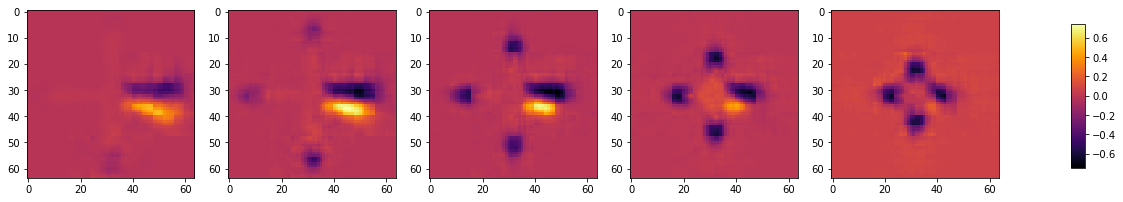

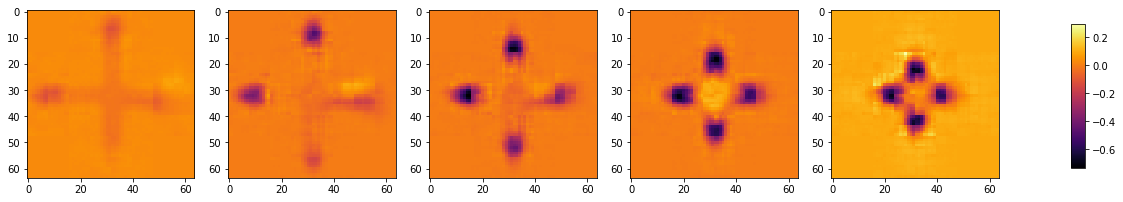

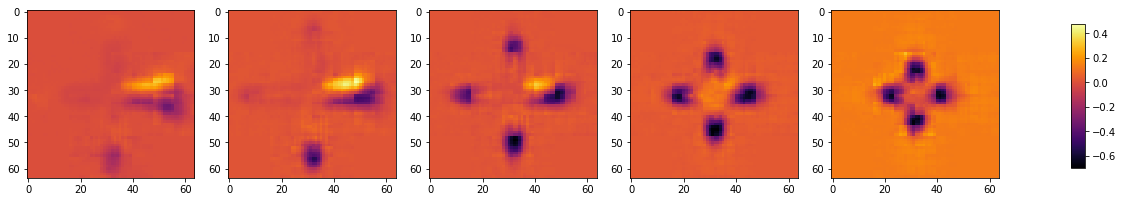

In [36]:
diff_sources_traj =[]
for i in range(number_of_sources):
    diff_sources_traj.append([sources_traj[i][j] - geodesic_images[j] for j in range(len(geodesic_images))])
for elt in diff_sources_traj:
    plot_images(elt)
